### Import Library and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn import tree
from sklearn.metrics import accuracy_score , confusion_matrix , mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn import linear_model, tree, metrics, model_selection, exceptions, ensemble, metrics
from sklearn.metrics import fbeta_score

In [2]:
data_train = pd.read_csv("Data/train_validation_dataset.csv")
data_test = pd.read_csv("Data/test_dataset.csv")

<b> Note: EDA in notebook `Data_Extraction_and_Exploratory_Data_Analysis`

### Combining train and test data for pre-processing

In [3]:
# concatenating train and test set for pre-processing
# add a column to label train and test data, where train=0, test=1.

data_train['dataset'] = 0
data_test['dataset'] = 1
data = pd.concat([data_train, data_test])
print(data.shape)

(124900, 40)


<b> Pre-processing

In [4]:
# Change date column
from datetime import datetime
date = data['date']
data['date'] = pd.to_datetime(date).dt.strftime('%m/%Y')

# replace field that's entirely space (or empty) with NaN.
data = data.replace(r'^\s*$', 'NA', regex=True)

# impute missing values NaN with 0.
data = data.replace(np.nan, 0)

In [5]:
data = data.drop(['fullvisitorid', 'Unnamed: 0'], axis=1)

In [6]:
numeric_col = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

In [7]:
numeric_data = data[numeric_col]

In [8]:
numeric_data=numeric_data.drop(['transactions_target', 'transactionrevenue_target','dataset'], axis=1)

In [9]:
import numpy as np
from sklearn import datasets, decomposition, cluster
import matplotlib.pyplot as plt

pca = decomposition.PCA(n_components ='mle')
xr = pca.fit_transform(numeric_data)

In [10]:
xr.shape

(124900, 19)

In [11]:
pca_output=pd.DataFrame(xr)

In [12]:
data2=data.drop(numeric_col, axis=1)

In [13]:
data2.shape

(124900, 15)

In [14]:
data2=pd.concat([data2.reset_index(), pca_output.reset_index(),data[['transactions_target', 'transactionrevenue_target','dataset']].reset_index()], axis=1).drop(['index'], axis=1)

<b> Transformations - Encode Categorical Data 

In [15]:
# Show Cateogrical columns using .select_dtypes()
cat_data = data2.select_dtypes(include=[object]) # use this for sklearn's encoders

cat_data_cols = data2.select_dtypes(
    include=[object]).columns  # use this for pd.get_dummies

print(cat_data.nunique())

date                 4
channelgrouping      8
campaign_today       5
medium_today         7
keyword_today      436
adcontent_today     24
devicecategory       3
continent            6
subcontinent        23
country            186
metro               71
city               354
operatingsystem      7
source_today         6
dtype: int64


In [16]:
data2 = pd.get_dummies(data2, columns=cat_data_cols)

In [17]:
for i in data2.columns:
    print(i)

ismobile
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
transactions_target
transactionrevenue_target
dataset
date_03/2017
date_04/2017
date_05/2017
date_06/2017
channelgrouping_(Other)
channelgrouping_Affiliates
channelgrouping_Direct
channelgrouping_Display
channelgrouping_Organic Search
channelgrouping_Paid Search
channelgrouping_Referral
channelgrouping_Social
campaign_today_(not set)
campaign_today_AW - Accessories
campaign_today_AW - Apparel
campaign_today_AW - Dynamic Search Ads Whole Site
campaign_today_Data Share Promo
medium_today_(none)
medium_today_(not set)
medium_today_affiliate
medium_today_cpc
medium_today_cpm
medium_today_organic
medium_today_referral
keyword_today_0
keyword_today_(Remarketing/Content targeting)
keyword_today_(automatic matching)
keyword_today_(not provided)
keyword_today_+Android +Gear
keyword_today_+Android +Merchandise
keyword_today_+Google +Gear
keyword_today_+Google +Merchandise
keyword_today_+Google +Products
keyword_today_+Google +Swag
keyword_t

#### Split data back into train and test

- Split March-May 2017 data into Train and Validate <br>
- Jun 2017 data as Test <br>
- Perform MinMax Scaling <br>

In [18]:
# move col 'dataset' to the last col.
data2 = data2[[c for c in data2 if c not in ['dataset']] + ['dataset']]
# move col 'transactions' to the last col.
data2 = data2[[c for c in data2 if c not in ['transactions_target']] + ['transactions_target']]

In [19]:
train = data2[data2['dataset'] == 0]
test = data2[data2['dataset'] == 1]

<b> Split train data to train-validation

In [20]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

X = train.drop(['transactions_target', 'transactionrevenue_target'], axis=1)
y = train['transactions_target']

X_train, X_val , y_train, y_val=model_selection.train_test_split(X,y,test_size=0.3, random_state=1234)

X_train = min_max_scaler.fit_transform(X_train)
X_val = min_max_scaler.transform(X_val)

X_test = test.drop(['transactions_target', 'transactionrevenue_target'], axis=1)
y_test = test['transactions_target']

X_test = min_max_scaler.transform(X_test)

# Check train and test datasets
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(66424, 1161)
(66424,)
(28468, 1161)
(28468,)
(30008, 1161)
(30008,)


## Classification Models

The following classification models were used: <br>
- Logistic Regression
- Random Forest
- Adaptive Boosting
- Light Gradient Boosting (LGB)
- Neural Network

<b> Define optimisation scorer

In [57]:
f2_scorer = metrics.make_scorer(metrics.fbeta_score, beta = 2)

<b> Define print score function

In [58]:
def print_score(model, X_test, y_test):
    predict=model.predict(X_test)
    print("Training score is {}".format(model.score(X_train, y_train)))
    print("Validation score is {}".format(model.score(X_test, y_test)))
    print('Recall:', recall_score(y_test, predict))
    print('Precision:', precision_score(y_test, predict))
    print('Accuracy:', accuracy_score(y_test, predict))
    print("f1:", f1_score(y_test, predict))
    print("f2:", fbeta_score(y_test, predict, beta=2), '\n')
    print('Classification Score')
    print(metrics.classification_report(y_test, predict))
    print('Confusion Matrix')
    print(metrics.confusion_matrix(y_test, predict))

## 1 - Logistic Regression

<b> Parameter Tuning

In [59]:
# parameters = {'solver': ['newton-cg', 'sag','lbfgs'],
#                'C': [0.01, 0.05, 0.1, 0.2, 0.5]
#                }

# rs_lr = model_selection.RandomizedSearchCV(LogisticRegression(penalty='l2', random_state=1, class_weight='balanced'),
#                                             parameters,scoring = f2_scorer,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=5, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_lr.fit(X_train, y_train)

# #results
# rs_lr.best_estimator_
# # LogisticRegression(C=0.5, class_weight='balanced', dual=False,
# #                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
# #                    max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
# #                    random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
# #                    warm_start=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.3min finished


LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

<b> Logistic Regression Model

In [60]:
lr =LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
lr.fit(X_train,y_train)

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

<b> Prediction with Validation Data (Logistic Regression)

In [61]:
print_score(lr, X_val, y_val)

Training score is 0.8469830181861978
Validation score is 0.8431923563299143
Recall: 0.8839368616527391
Precision: 0.17992817992817992
Accuracy: 0.8431923563299143
f1: 0.2989949748743719
f2: 0.49588498801958536 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     27391
           1       0.18      0.88      0.30      1077

    accuracy                           0.84     28468
   macro avg       0.59      0.86      0.61     28468
weighted avg       0.96      0.84      0.89     28468

Confusion Matrix
[[23052  4339]
 [  125   952]]


<b> Feature Importance (Logistic Regression)

In [62]:
lr_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': lr.coef_[0] })
print(lr_importance.sort_values('importance',ascending=False).head(10))

             feature  importance
7                  6   27.349701
4                  3   26.809540
1                  0    7.044747
15                14    5.740881
3                  2    3.736879
2                  1    3.710912
18                17    2.728386
553  country_Belgium    2.206678
584  country_Ecuador    2.195611
19                18    2.180052


In [63]:
print(lr_importance.sort_values('importance',ascending=False).tail(10))

                      feature  importance
954         city_Laguna Beach   -1.396065
43      medium_today_referral   -1.408388
706            country_Turkey   -1.556275
1159  source_today_b'youtube'   -2.213851
14                         13   -5.440845
13                         12   -7.602506
9                           8   -8.054451
5                           4   -9.711712
10                          9  -11.299665
6                           5  -13.065743


## 2 - Random Forest Modelling

<b> Parameter Tuning

In [64]:
# parameters = {'criterion': ['gini', 'entropy'],
#                'max_depth': [5, 10, 15, 20],
#                'min_samples_leaf': [1, 2],
#                'min_samples_split': [2, 4, 6],
#                'n_estimators': [10, 20, 30, 40],
#                'class_weight': ['balanced', 'balanced_subsample', None]
#                }

# rs_rf = model_selection.RandomizedSearchCV(ensemble.RandomForestClassifier(random_state=1),
#                                             parameters, scoring = f2_scorer,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=5, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_rf.fit(X_train, y_train)
# # print('best parameters: ', rs_rf.best_params_)

# ##results
# rs_rf.best_estimator_
# # RandomForestClassifier(bootstrap=True, class_weight='balanced',
# #                        criterion='gini', max_depth=20, max_features='auto',
# #                        max_leaf_nodes=None, min_impurity_decrease=0.0,
# #                        min_impurity_split=None, min_samples_leaf=2,
# #                        min_samples_split=6, min_weight_fraction_leaf=0.0,
# #                        n_estimators=40, n_jobs=None, oob_score=False,
# #                        random_state=1, verbose=0, warm_start=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.5min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

<b> Random Forest Model

In [65]:
rf = ensemble.RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

<b> Prediction with Validation Data (Random Forest)

In [66]:
print_score(rf, X_val, y_val)

Training score is 0.9373419246055642
Validation score is 0.9234930448222566
Recall: 0.8328690807799443
Precision: 0.30984455958549223
Accuracy: 0.9234930448222566
f1: 0.45166163141993954
f2: 0.6226572261557684 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     27391
           1       0.31      0.83      0.45      1077

    accuracy                           0.92     28468
   macro avg       0.65      0.88      0.71     28468
weighted avg       0.97      0.92      0.94     28468

Confusion Matrix
[[25393  1998]
 [  180   897]]


In [67]:
print_score(rf, X_val, y_val)

Training score is 0.9373419246055642
Validation score is 0.9234930448222566
Recall: 0.8328690807799443
Precision: 0.30984455958549223
Accuracy: 0.9234930448222566
f1: 0.45166163141993954
f2: 0.6226572261557684 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     27391
           1       0.31      0.83      0.45      1077

    accuracy                           0.92     28468
   macro avg       0.65      0.88      0.71     28468
weighted avg       0.97      0.92      0.94     28468

Confusion Matrix
[[25393  1998]
 [  180   897]]


<b> Feature Importance for Random Forest

In [68]:
rf_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': rf.feature_importances_ })
print(rf_importance.sort_values('importance',ascending=False).head(10))

   feature  importance
6        5    0.089939
4        3    0.071691
16      15    0.058834
7        6    0.057298
3        2    0.047468
17      16    0.046283
8        7    0.044870
5        4    0.041791
18      17    0.037098
9        8    0.035749


## 3 - Adaptive Boosting

<b> Parameter Tuning

In [ ]:
# parameters = {'base_estimator__criterion' : ["gini", "entropy"], 
#               'base_estimator__splitter' :   ["best", "random"],
#               'base_estimator__max_depth': [15, 20, 25, 30], 
#               'base_estimator__min_samples_split': list(range(15, 30, 5)),
#               'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1], 
#               'n_estimators': list(range(50, 200, 50))}

# DTC = tree.DecisionTreeClassifier(random_state = 2019, max_features = "auto", class_weight = "balanced")

# rs_ab = model_selection.RandomizedSearchCV(ensemble.AdaBoostClassifier(random_state = 2019, base_estimator = DTC), 
#                                   parameters, scoring = f2_scorer, 
#                                   cv = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2019),
#                                        iid=False, verbose=2, n_jobs=-1)

# rs_ab.fit(X_train, y_train)

# #results
# rs_ab.best_estimator_
# # AdaBoostClassifier(algorithm='SAMME',
# #                    base_estimator=DecisionTreeClassifier(class_weight='balanced',
# #                                                          criterion='gini',
# #                                                          max_depth=20,
# #                                                          max_features='auto',
# #                                                          max_leaf_nodes=None,
# #                                                          min_impurity_decrease=0.0,
# #                                                          min_impurity_split=None,
# #                                                          min_samples_leaf=1,
# #                                                          min_samples_split=20,
# #                                                          min_weight_fraction_leaf=0.0,
# #                                                          presort=False,
# #                                                          random_state=2019,
# #                                                          splitter='best'),
# #                    learning_rate=0.5, n_estimators=50, random_state=2019)

<b> AdaBoost Model

In [71]:
from sklearn.tree import DecisionTreeClassifier

ab= ensemble.AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=20,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=20,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2019,
                                                         splitter='best'),
                   learning_rate=0.5, n_estimators=50, random_state=2019)

ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=20,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=20,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2019,
                     

<b> Prediction with Validation Data (Adaboost)

In [72]:
print_score(ab, X_val, y_val)

Training score is 0.9753552932674937
Validation score is 0.9460446817479276
Recall: 0.6648096564531105
Precision: 0.3786356425171867
Accuracy: 0.9460446817479276
f1: 0.48247978436657685
f2: 0.5775125020164543 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     27391
           1       0.38      0.66      0.48      1077

    accuracy                           0.95     28468
   macro avg       0.68      0.81      0.73     28468
weighted avg       0.96      0.95      0.95     28468

Confusion Matrix
[[26216  1175]
 [  361   716]]


<b> Feature Importance for Adaptive Boosting

In [73]:
ab_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': ab.feature_importances_ })
print(ab_importance.sort_values('importance',ascending=False).head(10))

   feature  importance
7        6    0.069719
16      15    0.051313
3        2    0.049667
6        5    0.049608
4        3    0.040666
15      14    0.040468
5        4    0.040465
14      13    0.039064
12      11    0.038130
18      17    0.036364


## 4 - Neural Network

In [74]:
# from sklearn.neural_network import MLPClassifier
# parameters = {
#     'hidden_layer_sizes': [(32,24,10), (16,32,16), (32,16,8)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }

# rs_nn = model_selection.RandomizedSearchCV(MLPClassifier(random_state=2019, max_iter=100),
#                                             parameters,scoring = f2_scorer,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=5, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_nn.fit(X_train, y_train)
# rs_nn.best_estimator_

# # result
# # MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
# #               beta_2=0.999, early_stopping=False, epsilon=1e-08,
# #               hidden_layer_sizes=(32, 16, 8), learning_rate='adaptive',
# #               learning_rate_init=0.001, max_iter=100, momentum=0.9,
# #               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
# #               random_state=2019, shuffle=True, solver='adam', tol=0.0001,
# #               validation_fraction=0.1, verbose=False, warm_start=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 45.6min finished
C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 16, 8), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [75]:
from sklearn.neural_network import MLPClassifier

nn= MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 16, 8), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

nn.fit(X_train, y_train)

C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 16, 8), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

<b> Prediction with Validation Data (Neural Network)

In [76]:
print_score(nn, X_val, y_val)

Training score is 0.9703872094423702
Validation score is 0.9666643248559786
Recall: 0.39925719591457753
Precision: 0.587431693989071
Accuracy: 0.9666643248559786
f1: 0.4754007739082366
f2: 0.4265873015873016 

Classification Score
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     27391
           1       0.59      0.40      0.48      1077

    accuracy                           0.97     28468
   macro avg       0.78      0.69      0.73     28468
weighted avg       0.96      0.97      0.96     28468

Confusion Matrix
[[27089   302]
 [  647   430]]


## 5 - LightGBM

In [77]:
import lightgbm as lgb

<b> Parameter Tuning

In [78]:
# # coarse to fine tuning
# #parameter tuning guideline from: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# #Step 1 - coarse
# parameters = {'num_leaves': [10,20,30,40,50], 'min_data_in_leaf': [5, 10, 20, 30, 50, 100],'max_depth': [-1, 20, 40, 60, 100]}

# lgb_fit = model_selection.RandomizedSearchCV(lgb.LGBMClassifier(), parameters, scoring =  f2_scorer,
#                                    cv = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2019),
#                                             verbose=2, n_jobs=-1)
    
# lgb_fit.fit(X_train, y_train)
# print('best score:', lgb_fit.best_score_)
# print('best parameters: ', lgb_fit.best_params_)

# #results
# # best score: 0.41882923648645976
# # best parameters:  {'num_leaves': 40, 'min_data_in_leaf': 5, 'max_depth': 60}

# ##### Never do this ################################

# # Step 2 - fine
# # parameters = {'num_leaves': [30,50,70,90], 'min_data_in_leaf': [10,20,30,40],'max_depth': [100,120,140,160]}

# # lgb_fit = model_selection.RandomizedSearchCV(lgb.LGBMClassifier(), parameters, scoring =  f2_scorer,
# #                                    cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2019))
    
# # lgb_fit.fit(X_train, y_train)
# # print('best score:', lgb_fit.best_score_)
# # print('best parameters: ', lgb_fit.best_params_)
# # best score: 0.42790358761961755
# # best parameters:  {'num_leaves': 90, 'min_data_in_leaf': 10, 'max_depth': 160}

# # Note: to use step 1 tuning as it generate better score

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


best score: 0.41882923648645976
best parameters:  {'num_leaves': 40, 'min_data_in_leaf': 5, 'max_depth': 60}


<b> Light Gradient Boosting Model

In [81]:
lgb_c = lgb.LGBMClassifier(learning_rate = 0.04, n_estimators = 3200, boosting_type = 'dart', num_leaves = 40, min_data_in_leaf = 5, max_depth = 60)
lgb_c.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          eval_metric = None,
          verbose = 500)

[500]	valid_0's binary_logloss: 0.0811914
[1000]	valid_0's binary_logloss: 0.080201
[1500]	valid_0's binary_logloss: 0.0802238
[2000]	valid_0's binary_logloss: 0.0808529
[2500]	valid_0's binary_logloss: 0.0822284
[3000]	valid_0's binary_logloss: 0.0836595


LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.04, max_depth=60,
               min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=5,
               min_split_gain=0.0, n_estimators=3200, n_jobs=-1, num_leaves=40,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

<b> Prediction with Validation Data (LGB) 

In [82]:
print_score(lgb_c, X_val, y_val)

Training score is 0.9980729856678309
Validation score is 0.9692988618800056
Recall: 0.4103992571959146
Precision: 0.6490455212922174
Accuracy: 0.9692988618800056
f1: 0.502844141069397
f2: 0.442974543996793 

Classification Score
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     27391
           1       0.65      0.41      0.50      1077

    accuracy                           0.97     28468
   macro avg       0.81      0.70      0.74     28468
weighted avg       0.96      0.97      0.97     28468

Confusion Matrix
[[27152   239]
 [  635   442]]


In [83]:
lgb_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': lgb_c.feature_importances_ })
print(lgb_importance.sort_values('importance',ascending=False).head(10))

   feature  importance
4        3        8055
7        6        7810
1        0        6714
18      17        6198
16      15        6101
6        5        6075
5        4        5324
9        8        5265
13      12        5101
8        7        4773


### Precision Recall Chart - Validation Data

In [84]:
lr_proba_val=lr.predict_proba(X_val)[:, 1]
rf_proba_val=rf.predict_proba(X_val)[:, 1]
ab_proba_val=ab.predict_proba(X_val)[:, 1]
nn_proba_val=nn.predict_proba(X_val)[:, 1]
lgb_proba_val=lgb_c.predict_proba(X_val, num_iteration=lgb_c.best_iteration_)[:,1]

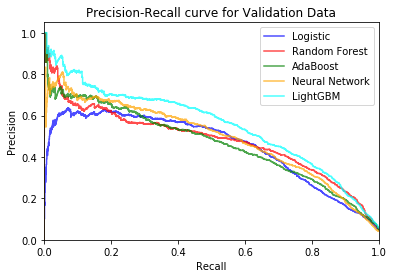

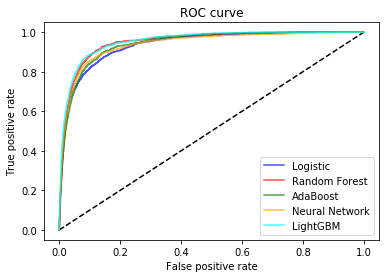

In [85]:
from inspect import signature

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_val, lr_proba_val)
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_val, rf_proba_val)
ab_precision, ab_recall, _ = metrics.precision_recall_curve(y_val, ab_proba_val)
nn_precision, nn_recall, _ = metrics.precision_recall_curve(y_val, nn_proba_val)
lgb_precision, lgb_recall, _ = metrics.precision_recall_curve(y_val, lgb_proba_val)

step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
plt.step(lr_recall, lr_precision, color='blue', alpha=0.7, where='post', label='Logistic')
plt.step(rf_recall, rf_precision, color='red', alpha=0.7, where='post', label='Random Forest')
plt.step(ab_recall, ab_precision, color='green', alpha=0.7, where='post', label='AdaBoost')
plt.step(nn_recall, nn_precision, color='orange', alpha=0.7, where='post', label='Neural Network')
plt.step(lgb_recall, lgb_precision, color='cyan', alpha=0.7, where='post', label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Validation Data')
plt.legend(loc='best')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_val, lr_proba_val)
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_proba_val)
fpr_ab, tpr_ab, _ = roc_curve(y_val, ab_proba_val)
fpr_nn, tpr_nn, _ = roc_curve(y_val, nn_proba_val)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, lgb_proba_val)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic',color='blue', alpha=0.7)
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color='red', alpha=0.7)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost',color='green', alpha=0.7)
plt.plot(fpr_nn, tpr_nn, label='Neural Network',color='orange', alpha=0.7)
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM',color='cyan', alpha=0.7)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Model Comparison - Test Data

<b> 1. Prediction with Test Data (Logistic Regression)

In [86]:
print ('Logistic Regression')
print_score(lr, X_test, y_test)

Logistic Regression
Training score is 0.8469830181861978
Validation score is 0.8339109570781125
Recall: 0.8735244519392917
Precision: 0.17649063032367973
Accuracy: 0.8339109570781125
f1: 0.29365079365079366
f2: 0.48803467118899563 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.83      0.91     28822
           1       0.18      0.87      0.29      1186

    accuracy                           0.83     30008
   macro avg       0.59      0.85      0.60     30008
weighted avg       0.96      0.83      0.88     30008

Confusion Matrix
[[23988  4834]
 [  150  1036]]


<b> 2. Prediction with Test Data (Random Forest)

In [87]:
print ('Random Forest')
print_score(rf, X_test, y_test)

Random Forest
Training score is 0.9373419246055642
Validation score is 0.9117235403892295
Recall: 0.8288364249578415
Precision: 0.2866724992709245
Accuracy: 0.9117235403892295
f1: 0.42600216684723735
f2: 0.6013703658387373 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     28822
           1       0.29      0.83      0.43      1186

    accuracy                           0.91     30008
   macro avg       0.64      0.87      0.69     30008
weighted avg       0.96      0.91      0.93     30008

Confusion Matrix
[[26376  2446]
 [  203   983]]


<b> 3. Prediction with Test Data (Adaboost)

In [88]:
print ('AdaBoost')
print_score(ab, X_test, y_test)

AdaBoost
Training score is 0.9753552932674937
Validation score is 0.9445481205011996
Recall: 0.6037099494097807
Precision: 0.374869109947644
Accuracy: 0.9445481205011996
f1: 0.46253229974160204
f2: 0.5380222422602946 

Classification Score
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     28822
           1       0.37      0.60      0.46      1186

    accuracy                           0.94     30008
   macro avg       0.68      0.78      0.72     30008
weighted avg       0.96      0.94      0.95     30008

Confusion Matrix
[[27628  1194]
 [  470   716]]


<b> 4. Prediction with Test Data (Neural Network)

In [89]:
print ('Neural Network')
print_score(nn, X_test, y_test)

Neural Network
Training score is 0.9703872094423702
Validation score is 0.9637096774193549
Recall: 0.32377740303541314
Precision: 0.5722801788375559
Accuracy: 0.9637096774193549
f1: 0.41357027463651047
f2: 0.3545706371191136 

Classification Score
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28822
           1       0.57      0.32      0.41      1186

    accuracy                           0.96     30008
   macro avg       0.77      0.66      0.70     30008
weighted avg       0.96      0.96      0.96     30008

Confusion Matrix
[[28535   287]
 [  802   384]]


<b> 5. Prediction with Validation Data (Light Gradient Boosting)

In [90]:
print_score(lgb_c, X_test, y_test)

Training score is 0.9980729856678309
Validation score is 0.9636763529725406
Recall: 0.33136593591905567
Precision: 0.5695652173913044
Accuracy: 0.9636763529725406
f1: 0.41897654584221744
f2: 0.361612072138388 

Classification Score
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28822
           1       0.57      0.33      0.42      1186

    accuracy                           0.96     30008
   macro avg       0.77      0.66      0.70     30008
weighted avg       0.96      0.96      0.96     30008

Confusion Matrix
[[28525   297]
 [  793   393]]


### Precision Recall Chart - Test Data

In [95]:
lr_proba_test=lr.predict_proba(X_test)[:, 1]
rf_proba_test=rf.predict_proba(X_test)[:, 1]
ab_proba_test=ab.predict_proba(X_test)[:, 1]
nn_proba_test=nn.predict_proba(X_test)[:, 1]
lgb_proba_test=lgb_c.predict_proba(X_test, num_iteration=lgb_c.best_iteration_)[:,1]

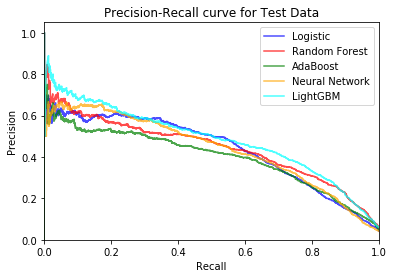

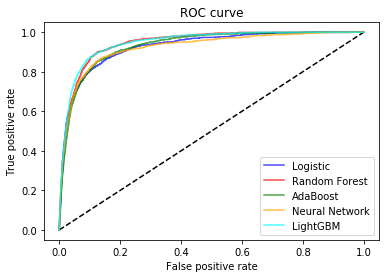

In [96]:
from inspect import signature

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, lr_proba_test)
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_test, rf_proba_test)
ab_precision, ab_recall, _ = metrics.precision_recall_curve(y_test, ab_proba_test)
nn_precision, nn_recall, _ = metrics.precision_recall_curve(y_test, nn_proba_test)
lgb_precision, lgb_recall, _ = metrics.precision_recall_curve(y_test, lgb_proba_test)

step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
plt.step(lr_recall, lr_precision, color='blue', alpha=0.7, where='post', label='Logistic')
plt.step(rf_recall, rf_precision, color='red', alpha=0.7, where='post', label='Random Forest')
plt.step(ab_recall, ab_precision, color='green', alpha=0.7, where='post', label='AdaBoost')
plt.step(nn_recall, nn_precision, color='orange', alpha=0.7, where='post', label='Neural Network')
plt.step(lgb_recall, lgb_precision, color='cyan', alpha=0.7, where='post', label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Test Data')
plt.legend(loc='best')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba_test)
fpr_ab, tpr_ab, _ = roc_curve(y_test, ab_proba_test)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_proba_test)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_proba_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic',color='blue', alpha=0.7)
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color='red', alpha=0.7)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost',color='green', alpha=0.7)
plt.plot(fpr_nn, tpr_nn, label='Neural Network',color='orange', alpha=0.7)
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM',color='cyan', alpha=0.7)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Threshold Curves - Test Data

In [97]:
def plot_prec_recall_vs_tresh(y_test, proba):
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, proba)
    
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.xlim([0,1.05])
    plt.ylim([0,1.05])

<b> Logistic Regression

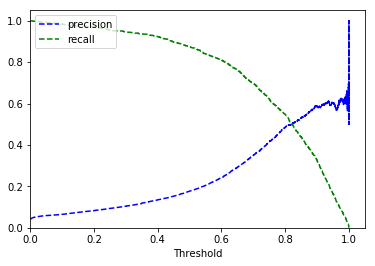

In [98]:
plot_prec_recall_vs_tresh(y_test, lr_proba_test)
plt.show()

<b> Random Forest

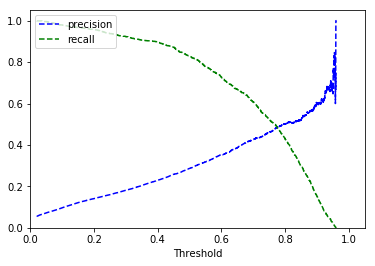

In [99]:
plot_prec_recall_vs_tresh(y_test, rf_proba_test)
plt.show()

<b> Adaptive Boosting

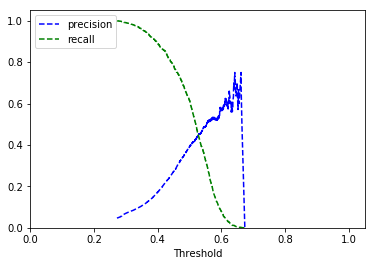

In [100]:
plot_prec_recall_vs_tresh(y_test, ab_proba_test)
plt.show()

<b> Neural Network

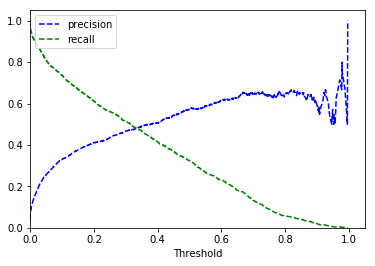

In [101]:
plot_prec_recall_vs_tresh(y_test, nn_proba_test)
plt.show()

<b> Light GBM

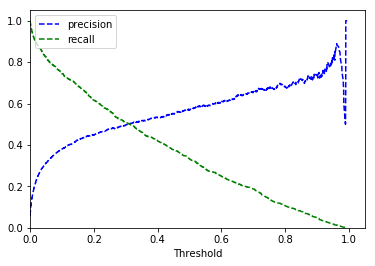

In [102]:
plot_prec_recall_vs_tresh(y_test, lgb_proba_test)
plt.show()

### Exporting Results

<b> Feature Importance

In [103]:
lr_importance.to_csv('Feature_Importance_05_LR.csv')
rf_importance.to_csv('Feature_Importance_05_RF.csv')
ab_importance.to_csv('Feature_Importance_05_AB.csv')
lgb_importance.to_csv('Feature_Importance_05_LGB.csv')

<b> Results

In [104]:
combine_proba=pd.concat([pd.DataFrame(lr_proba_test, columns=['Logistic_Regression']).reset_index(),
                         pd.DataFrame(rf_proba_test, columns=['Random_Forest']).reset_index(),
                         pd.DataFrame(ab_proba_test, columns=['AdaBoost']).reset_index(),
                         pd.DataFrame(nn_proba_test, columns=['Neural_Network']).reset_index(),
                         pd.DataFrame(lgb_proba_test, columns=['Light_GBM']).reset_index()
                        ], axis=1).drop('index', axis=1)

In [105]:
combine_with_data=pd.concat([pd.DataFrame(X_test, columns=X.columns).reset_index(), 
                             pd.DataFrame(y_test).reset_index(), 
                             combine_proba.reset_index()], axis=1).drop('index', axis=1)

In [106]:
combine_with_data.head(10)

,ismobile,0,1,2,3,4,5,6,7,8,...,source_today_b'others',source_today_b'partners',source_today_b'youtube',dataset,transactions_target,Logistic_Regression,Random_Forest,AdaBoost,Neural_Network,Light_GBM
0,1.0,1.478250e-14,0.080435,0.242843,0.303077,0.261830,0.359706,0.162579,0.415140,0.468828,...,0.0,0.0,0.0,1.0,0,0.182299,0.098889,0.282537,0.001047,0.000555
1,1.0,1.413670e-14,0.080435,0.242312,0.246204,0.280017,0.354402,0.201404,0.411993,0.464427,...,0.0,0.0,0.0,1.0,0,0.000359,0.001321,0.268941,0.000029,0.000004
2,0.0,1.413062e-14,0.080435,0.242307,0.245702,0.280177,0.354355,0.201747,0.411965,0.464388,...,0.0,0.0,0.0,1.0,0,0.093274,0.013788,0.272839,0.000314,0.000248
3,0.0,1.413361e-14,0.080435,0.242309,0.245934,0.280103,0.354377,0.201589,0.411978,0.464406,...,0.0,0.0,0.0,1.0,0,0.079134,0.004837,0.287846,0.003369,0.000099
4,1.0,1.416228e-14,0.080435,0.242333,0.248447,0.279299,0.354611,0.199873,0.412117,0.464600,...,1.0,0.0,0.0,1.0,0,0.054592,0.023955,0.273794,0.000077,0.000097
5,0.0,1.412813e-14,0.080435,0.242305,0.245470,0.280251,0.354334,0.201906,0.411953,0.464370,...,0.0,0.0,0.0,1.0,0,0.017079,0.002372,0.272103,0.000041,0.000011
6,0.0,1.414109e-14,0.080435,0.242321,0.247210,0.279695,0.354490,0.200718,0.412057,0.464337,...,0.0,0.0,0.0,1.0,0,0.438354,0.089417,0.356403,0.002752,0.003074
7,1.0,1.413529e-14,0.080435,0.242311,0.246088,0.280054,0.354391,0.201483,0.411987,0.464418,...,0.0,0.0,0.0,1.0,0,0.084687,0.008096,0.271584,0.001568,0.000059
8,0.0,4.000186e-14,0.080435,0.251603,0.249900,0.276130,0.353637,0.196389,0.412473,0.459916,...,0.0,0.0,0.0,1.0,0,0.461259,0.363664,0.401564,0.018349,0.006036
9,0.0,1.413529e-14,0.080435,0.242311,0.246088,0.280054,0.354391,0.201483,0.411987,0.464418,...,0.0,0.0,0.0,1.0,0,0.536614,0.114931,0.404392,0.010758,0.011354


In [107]:
combine_with_data.to_csv('Result_05_w_PCA.csv')

<b> Save Model

In [108]:
import pickle

with open('LR_05.pkl', 'wb') as file:  
    pickle.dump(lr, file)
    
with open('RF_05.pkl', 'wb') as file:  
    pickle.dump(rf, file)
    
with open('AB_05.pkl', 'wb') as file:  
    pickle.dump(ab, file)
    
with open('NN_05.pkl', 'wb') as file:  
    pickle.dump(nn, file)

with open('LightGBM_05.pkl', 'wb') as file:  
    pickle.dump(lgb_c, file)

## Anomaly Detection 

#### Data Preparation

<b> Reconfigure X_train and X_test for Anomaly detection </b><br>
concat X_train and y_train -> this is for fit <br>
slice out only the values for 'transasction_target==0' -> this is for predict <br>
concat X_test and y_test -> this is for validation <br>

In [109]:
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import IsolationForest

min_max_scaler2 = preprocessing.MinMaxScaler()

train_w_label = pd.concat([X, y], axis=1)

#only keep the majority class
train_anomaly = train_w_label.loc[train_w_label['transactions_target'] == 0].drop('transactions_target', axis=1)
X_train_anomaly = min_max_scaler2.fit_transform(train_anomaly)

#get the validation x and y
X_val_anomaly = min_max_scaler2.transform(train_w_label.drop('transactions_target', axis=1))
y_val_anomaly = train_w_label['transactions_target']

test_w_label=pd.concat([pd.DataFrame(X_test, columns=X.columns).reset_index(), y_test.reset_index()], axis=1).drop('index', axis=1)
X_test_anomaly=min_max_scaler2.transform(test_w_label.drop('transactions_target', axis=1))
y_test_anomaly=test_w_label['transactions_target']

<b> Print Score function for Anomaly Detection 

In [110]:
def print_score_anomaly (y_test, predict):
    print('Recall:', recall_score(y_test, predict))
    print('Precision:', precision_score(y_test, predict))
    print('Accuracy:', accuracy_score(y_test, predict))
    print("f1:", f1_score(y_test, predict))
    print("f2:", fbeta_score(y_test, predict, beta=2), '\n')
    print('Classification Score')
    print(metrics.classification_report(y_test, predict))
    print('Confusion Matrix')
    print(metrics.confusion_matrix(y_test, predict))

## 6 - OneClassSVM

In [114]:
oneclass = svm.OneClassSVM(kernel='rbf', nu=0.0388, gamma=0.01, verbose=2)
oneclass.fit(X_train_anomaly)

[LibSVM]

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.01, kernel='rbf',
            max_iter=-1, nu=0.0388, random_state=None, shrinking=True,
            tol=0.001, verbose=2)

In [115]:
oneclass_pred = oneclass.predict(X_test_anomaly)
unique, counts = np.unique(oneclass_pred, return_counts=True)
print (np.asarray((unique, counts)).T)
oneclass_pred=pd.DataFrame(oneclass_pred).replace(1,0).replace(-1,1).values.tolist()

[[   -1 23654]
 [    1  6354]]


<b> Prediction with Test Data (One Class SVM) 

In [116]:
print_score_anomaly(y_test_anomaly, oneclass_pred)

Recall: 0.7116357504215851
Precision: 0.03568106874101632
Accuracy: 0.22847240735803787
f1: 0.06795491143317231
f2: 0.14860201422635397 

Classification Score
              precision    recall  f1-score   support

           0       0.95      0.21      0.34     28822
           1       0.04      0.71      0.07      1186

    accuracy                           0.23     30008
   macro avg       0.49      0.46      0.20     30008
weighted avg       0.91      0.23      0.33     30008

Confusion Matrix
[[ 6012 22810]
 [  342   844]]


## 7 - Isolation Forest

In [111]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), 
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

iforest.fit(X_train_anomaly)

C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.12,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=42, verbose=0, warm_start=False)

In [112]:
iforest_pred = iforest.predict(X_test_anomaly)
unique, counts = np.unique(iforest_pred, return_counts=True)
print (np.asarray((unique, counts)).T)
iforest_pred=pd.DataFrame(iforest_pred).replace(1,0).replace(-1,1).values.tolist()

C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


[[   -1 10059]
 [    1 19949]]


<b> Prediction with Test Data (Isolation Forest) 

In [113]:
print_score_anomaly(y_test_anomaly, iforest_pred)

Recall: 0.12563237774030353
Precision: 0.014812605626801869
Accuracy: 0.6351972807251399
f1: 0.026500666963094707
f2: 0.05032763628994123 

Classification Score
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     28822
           1       0.01      0.13      0.03      1186

    accuracy                           0.64     30008
   macro avg       0.48      0.39      0.40     30008
weighted avg       0.91      0.64      0.75     30008

Confusion Matrix
[[18912  9910]
 [ 1037   149]]


<b> Save Models

In [ ]:
import pickle

with open('OneSVM_04.pkl', 'wb') as file:  
    pickle.dump(oneclass, file)
    
with open('iForest_04.pkl', 'wb') as file:  
    pickle.dump(iforest, file)
